## Work
1. 請嘗試將 preproc_x 替換成以每筆資料的 min/max 進行標準化至 -1 ~ 1 間，再進行訓練
2. 請嘗試將 mlp 疊更深 (e.g 5~10 層)，進行訓練後觀察 learning curve 的走勢
3. (optional) 請改用 GPU 進行訓練 (如果你有 GPU 的話)，比較使用 CPU 與 GPU 的訓練速度

In [1]:
## 確認硬體資源
!nvidia-smi


Fri Apr  5 14:26:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060    Off  | 00000000:08:00.0  On |                  N/A |
| 47%   40C    P2    34W / 160W |    699MiB /  5901MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import os
import keras
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5  # 程序最多只能占用指定gpu50%的显存
config.gpu_options.allow_growth = True      #程序按需申请内存
sess = tf.Session(config = config)



Using TensorFlow backend.


In [24]:
train, test = keras.datasets.cifar10.load_data()

In [25]:
## 資料前處理
from sklearn.preprocessing import MinMaxScaler
# MinMaxScaler(copy=True, feature_range=(-1, 1))
scaler = MinMaxScaler(copy=True, feature_range=(-1, 1))

def preproc_x(x, flatten=True):
    if flatten:
        x = x.reshape((len(x), -1))
    x = scaler.fit_transform(x)
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [26]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

/home/tekwell/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [31]:
x_train.max()

1.0

In [27]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

# model.summary()

In [32]:
x_train.shape[1:]

(3072,)

In [33]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


In [34]:
## 超參數設定
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 256

In [35]:
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

In [36]:
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [37]:
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.6769 - acc: 0.4053 - val_loss: 1.5131 - val_acc: 0.4713
Epoch 2/100
50000/50000 [==============================] - 1s 28us/step - loss: 1.4455 - acc: 0.4915 - val_loss: 1.4292 - val_acc: 0.4985
Epoch 3/100
50000/50000 [==============================] - 1s 29us/step - loss: 1.3241 - acc: 0.5342 - val_loss: 1.3904 - val_acc: 0.5069
Epoch 4/100
50000/50000 [==============================] - 1s 29us/step - loss: 1.2251 - acc: 0.5716 - val_loss: 1.3717 - val_acc: 0.5227
Epoch 5/100
50000/50000 [==============================] - 1s 29us/step - loss: 1.1388 - acc: 0.5989 - val_loss: 1.3752 - val_acc: 0.5220
Epoch 6/100
50000/50000 [==============================] - 1s 29us/step - loss: 1.0549 - acc: 0.6300 - val_loss: 1.3688 - val_acc: 0.5285
Epoch 7/100
50000/50000 [==============================] - 1s 29us/step - loss: 0.9764 - acc: 0.6536 - val_loss: 1.3996 - 

50000/50000 [==============================] - 1s 29us/step - loss: 0.1095 - acc: 0.9649 - val_loss: 3.9187 - val_acc: 0.5238
Epoch 60/100
50000/50000 [==============================] - 1s 29us/step - loss: 0.1005 - acc: 0.9674 - val_loss: 3.9305 - val_acc: 0.5248
Epoch 61/100
50000/50000 [==============================] - 2s 30us/step - loss: 0.0608 - acc: 0.9789 - val_loss: 3.9927 - val_acc: 0.5320
Epoch 62/100
50000/50000 [==============================] - 2s 30us/step - loss: 0.0603 - acc: 0.9798 - val_loss: 4.0479 - val_acc: 0.5304
Epoch 63/100
50000/50000 [==============================] - 1s 30us/step - loss: 0.1038 - acc: 0.9677 - val_loss: 3.9694 - val_acc: 0.5230
Epoch 64/100
50000/50000 [==============================] - 2s 30us/step - loss: 0.1273 - acc: 0.9598 - val_loss: 4.0490 - val_acc: 0.5168
Epoch 65/100
50000/50000 [==============================] - 1s 29us/step - loss: 0.0825 - acc: 0.9728 - val_loss: 4.0581 - val_acc: 0.5274
Epoch 66/100
50000/50000 [==============

KeyboardInterrupt: 

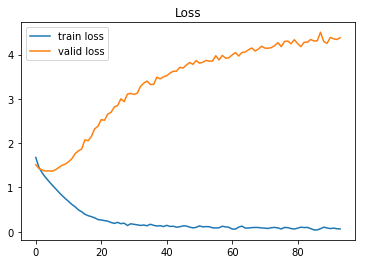

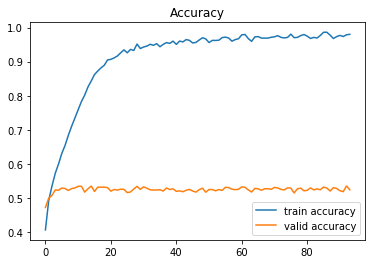

In [38]:
import matplotlib.pyplot as plt


train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]

train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [39]:
keras.backend.clear_session()

In [40]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128, 64, 32, 16 ]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


In [41]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
hidden_layer5 (Dense)        (None, 32)                2080      
_________________________________________________________________
hidden_layer6 (Dense)        (None, 16)                528       
__________

In [42]:
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

In [43]:
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 2s 38us/step - loss: 1.8431 - acc: 0.3440 - val_loss: 1.6207 - val_acc: 0.4331
Epoch 2/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5524 - acc: 0.4499 - val_loss: 1.5576 - val_acc: 0.4457
Epoch 3/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4296 - acc: 0.4951 - val_loss: 1.4535 - val_acc: 0.4894
Epoch 4/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3303 - acc: 0.5303 - val_loss: 1.4263 - val_acc: 0.4981
Epoch 5/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.2471 - acc: 0.5593 - val_loss: 1.3828 - val_acc: 0.5129
Epoch 6/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.1697 - acc: 0.5864 - val_loss: 1.3688 - val_acc: 0.5210
Epoch 7/100
50000/50000 [==============================] - 2s 34us/step - loss: 1.0946 - acc: 0.6120 - val_loss: 1.3676 - 

50000/50000 [==============================] - 2s 33us/step - loss: 0.0980 - acc: 0.9671 - val_loss: 3.6019 - val_acc: 0.5195
Epoch 60/100
50000/50000 [==============================] - 2s 32us/step - loss: 0.1078 - acc: 0.9639 - val_loss: 3.5069 - val_acc: 0.5253
Epoch 61/100
50000/50000 [==============================] - 2s 32us/step - loss: 0.0963 - acc: 0.9673 - val_loss: 3.5798 - val_acc: 0.5306
Epoch 62/100
50000/50000 [==============================] - 2s 32us/step - loss: 0.0758 - acc: 0.9747 - val_loss: 3.7213 - val_acc: 0.5279
Epoch 63/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.1219 - acc: 0.9608 - val_loss: 3.5764 - val_acc: 0.5290
Epoch 64/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.1040 - acc: 0.9665 - val_loss: 3.5636 - val_acc: 0.5243
Epoch 65/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.0762 - acc: 0.9743 - val_loss: 3.8506 - val_acc: 0.5240
Epoch 66/100
50000/50000 [==============

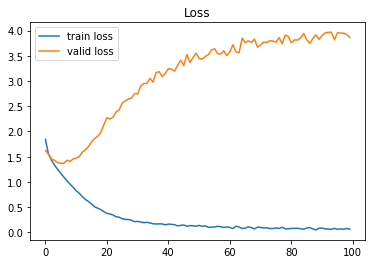

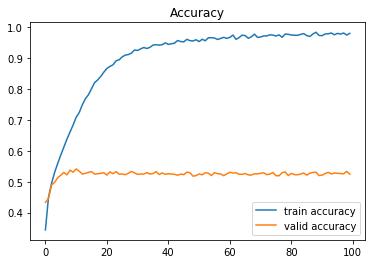

In [44]:
import matplotlib.pyplot as plt


train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]

train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()